In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm as normal, binom
import bplot as bp
from scipy.optimize import minimize
from scipy.special import loggamma
import patsy
import multiprocessing
from joblib import Parallel, delayed

from math314 import optim, pbootstrap as bootstrap, adjustedR2 as ar2

# 2 December 2019

In [4]:
df = pd.read_csv("https://raw.githubusercontent.com/roualdes/data/master/possum.csv")

In [11]:
r=df[["headL","totalL"]].corr()["totalL"][0]
r*r

0.4776104985770261

"Head length can explain total length variation by about 47.7%"

In [17]:
X = patsy.dmatrix("~ headL", data=df)
yX = np.c_[df.totalL, X]
betahat = optim(yX)
N = yX.shape[0]
k = yX.shape[1]-1
mu = np.full(N, np.nan)
for n in range(N):
    mu[n] = np.sum(yX[n, 1:] * betahat)

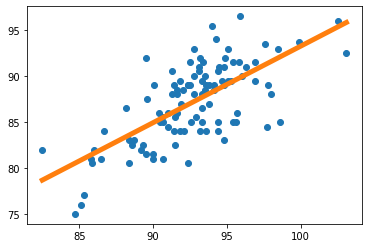

In [18]:
bp.point(df.headL, df.totalL)
bp.line(df['headL'], mu, color = bp.color[1], size=5)

In [20]:
ar2(df.totalL, mu, k)

0.4724890328604636

We use adjusted $R^2$ which explains
$$1-\frac{\text{Variance in error}}{\text{Variance in variable}} * \frac{\text{Number of observations - 1}}{\text{Number of observations - number of explanatory parameters}}$$

By this formula, adjusted $R^2$ will always be more conservative than $R^2$

We are going to work on extending the model we have so far. We will attempt to combine k-means and simple linear regression.

## K - Means
Y - is going to be a numerical variable, X is a categorical. For this model, we are trying to predict y based off of the level on the X axis explanatory variable. We focused on the mean for a base level and then the offset for each other level relative to the first mean.

We had a model that said the response variable (numerical observation Y) is going to be normal random variables with a mean that depended on the level we're looking at:
$$Y_n\sim N(\mu_n, \sigma^2)$$
$$\mu_n = \beta_0 + \beta_1*X_B + \beta_2 * X_C$$

## Simple Linear Regression
Y and X are both numerical variables for Simple Linear Regression. The biggest difference between this and K-Means is that X is numerical and not categorical.
$$Y_n \sim N(\mu_n, \sigma^2)$$
$$\mu_n = \beta_0 + \beta_1*X_n$$

## Multiple Linear Regression
Multiple explanatory variables to explain a single response variable. This is a combination of the K-Means model and the Simple Linear Regression model. We wish to take a numerical explanatory variable and a categorical explanatory variable to attempt to explain a response variable.
$$\mu_n = \beta_0+\beta_1*X_M+\beta_2*\text{headL}_n$$

This means to find the intercept for (males in this instance females being the base), we could find $\beta_0 + \beta_1$
and we can show females line as $\beta_0 + \beta_2 * \text{headL}_n$ and for males $(\beta_0 + \beta_1) + \beta_2 * \text{headL}_n$

In [28]:
X = patsy.dmatrix(" ~ C(sex) + headL", data=df)
yX = np.c_[df.totalL, X]
betahat = optim(yX)

In [29]:
betahat

array([ 8.26149176, -2.06457808,  0.86431351])

The rest of our code magically works, as long as we have the correct design matrix

If a female possum had no head length, we would expect it to have a total length of 8.26cm  
If a male possum had no head length, we would expect it to have a total length of (8.26 - 2.06)cm  
For both male and female possums, we could expect that for every 1mm of head length increase, we would expect an 0.864 cm total length increase.

In [37]:
X = patsy.dmatrix(" ~ C(sex) + headL + C(sex):headL", data=df)
yX = np.c_[df.totalL, X]
betahat = optim(yX)
betahat

array([-28.72162395,  45.08366762,   1.26565461,  -0.51073421])